In this notebook we're going to investigate a range of different architectures for the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/).  The video states that vgg.py and ``vgg_ft()`` from utils.py have been updated to include VGG with batch normalization, but this is not the case.  We've instead created a new file [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py) and an additional method ``vgg_ft_bn()`` (which is already in utils.py) which we use in this notebook.

In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
#path = "data/fish/sample/"
path = "/home/ubuntu/data/fisheries/"
batch_size=64

In [4]:
batches = get_batches(path+'train', batch_size=batch_size, shuffle=False)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)
test_batches = get_batches(path+'test', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.
Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


Sometimes it's helpful to have just the filenames, without the path.

In [5]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

## Setup dirs

We create the validation and sample sets in the usual way.

In [4]:
%cd /home/ubuntu/data/fisheries
%cd train
%mkdir ../valid

/home/ubuntu/data/fisheries
/home/ubuntu/data/fisheries/train


In [5]:
g = glob('*')
for d in g: os.mkdir('../valid/'+d)

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(500): os.rename(shuf[i], '../valid/' + shuf[i])

In [6]:
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

In [7]:
from shutil import copyfile

g = glob('*')
for d in g: 
    os.mkdir('../sample/train/'+d)
    os.mkdir('../sample/valid/'+d)

In [8]:
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(400): copyfile(shuf[i], '../sample/train/' + shuf[i])

%cd ../valid

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/valid/' + shuf[i])

%cd ..

/home/ubuntu/data/fisheries/valid
/home/ubuntu/data/fisheries


In [10]:
%mkdir results
%mkdir sample/results


mkdir: cannot create directory ‘sample/results’: No such file or directory
/home/ubuntu/git/courses/deeplearning1/nbs


In [11]:
%cd /home/ubuntu/git/courses/deeplearning1/nbs

/home/ubuntu/git/courses/deeplearning1/nbs


## Basic VGG

We start with our usual VGG approach.  We will be using VGG with batch normalization.  We explained how to add batch normalization to VGG in the [imagenet_batchnorm notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/imagenet_batchnorm.ipynb).  VGG with batch normalization is implemented in [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py), and there is a version of ``vgg_ft`` (our fine tuning function) with batch norm called ``vgg_ft_bn`` in [utils.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py).

### Initial model

First we create a simple fine-tuned VGG model to be our starting point.

In [7]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)

In [64]:
trn = get_data(path+'train')
val = get_data(path+'valid')

Found 3277 images belonging to 8 classes.


KeyboardInterrupt: 

In [65]:
test = get_data(path+'test')

Found 1000 images belonging to 1 classes.


KeyboardInterrupt: 

In [13]:
save_array(path+'results/trn.dat', trn)
save_array(path+'results/val.dat', val)

In [14]:
save_array(path+'results/test.dat', test)

In [66]:
trn = load_array(path+'results/trn.dat')
val = load_array(path+'results/val.dat')

In [26]:
test = load_array(path+'results/test.dat')

In [17]:
gen = image.ImageDataGenerator()

In [18]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 178s - loss: 2.8913 - acc: 0.4709 - val_loss: 1.2240 - val_acc: 0.6760
Epoch 2/3
3277/3277 [==============================] - 178s - loss: 1.5545 - acc: 0.6439 - val_loss: 0.7772 - val_acc: 0.7900
Epoch 3/3
3277/3277 [==============================] - 178s - loss: 1.1826 - acc: 0.7196 - val_loss: 0.7010 - val_acc: 0.8180


In [20]:
model.save_weights(path+'results/vgg1.h5')

### Precompute convolutional output

We pre-compute the output of the last convolution layer of VGG, since we're unlikely to need to fine-tune those layers. (All following analysis will be done on just the pre-computed convolutional features.)

In [22]:
model.load_weights(path+'results/ft1.h5')

In [33]:
conv_layers,fc_layers = split_at(model, Convolution2D)

In [34]:
conv_model = Sequential(conv_layers)

In [25]:
conv_feat = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)

In [35]:
conv_test_feat = conv_model.predict(test)

In [27]:
save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_feat.dat', conv_feat)

In [28]:
save_array(path+'results/conv_test_feat.dat', conv_test_feat)

In [5]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')

In [48]:
conv_test_feat = load_array(path+'results/conv_test_feat.dat')

In [22]:
conv_val_feat.shape

(500, 512, 14, 14)

### Train model

We can now create our first baseline model - a simple 3-layer FC net.

In [27]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

In [28]:
p=0.6

In [29]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 9s - loss: 1.1113 - acc: 0.6741 - val_loss: 0.9704 - val_acc: 0.8280
Epoch 2/3
3277/3277 [==============================] - 9s - loss: 0.3003 - acc: 0.9103 - val_loss: 0.2819 - val_acc: 0.9580
Epoch 3/3
3277/3277 [==============================] - 9s - loss: 0.1725 - acc: 0.9478 - val_loss: 0.2151 - val_acc: 0.9560


In [36]:
bn_model.optimizer.lr = 1e-4

In [37]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/7
3277/3277 [==============================] - 9s - loss: 0.1060 - acc: 0.9704 - val_loss: 0.2143 - val_acc: 0.9520
Epoch 2/7
3277/3277 [==============================] - 9s - loss: 0.0683 - acc: 0.9823 - val_loss: 0.1961 - val_acc: 0.9540
Epoch 3/7
3277/3277 [==============================] - 9s - loss: 0.0590 - acc: 0.9847 - val_loss: 0.2216 - val_acc: 0.9500
Epoch 4/7
3277/3277 [==============================] - 9s - loss: 0.0489 - acc: 0.9847 - val_loss: 0.1579 - val_acc: 0.9760
Epoch 5/7
3277/3277 [==============================] - 9s - loss: 0.0323 - acc: 0.9893 - val_loss: 0.1729 - val_acc: 0.9700
Epoch 6/7
3277/3277 [==============================] - 9s - loss: 0.0300 - acc: 0.9930 - val_loss: 0.2192 - val_acc: 0.9680
Epoch 7/7
3277/3277 [==============================] - 9s - loss: 0.0241 - acc: 0.9936 - val_loss: 0.2367 - val_acc: 0.9620


In [39]:
bn_model.save_weights(path+'results/vgg2_9620.h5')

In [40]:
bn_model.evaluate(conv_val_feat, val_labels)

500/500 [==============================] - 0s     


[0.23669385994598269, 0.96199999999999997]

In [30]:
bn_model.load_weights(path+'results/vgg2_9620.h5')

In [36]:
preds = bn_model.predict(conv_test_feat)

In [37]:
preds[:5]

array([[  9.6853e-01,   1.4112e-02,   1.6608e-03,   1.6136e-03,   2.6789e-04,   9.9496e-03,
          8.0711e-04,   3.0584e-03],
       [  4.9321e-01,   3.4661e-02,   4.7434e-02,   8.5076e-03,   2.6046e-03,   3.8383e-01,
          1.6055e-02,   1.3698e-02],
       [  1.1632e-01,   2.1974e-03,   1.9341e-03,   4.2466e-03,   8.3049e-01,   3.9783e-04,
          4.4250e-02,   1.6097e-04],
       [  9.9840e-01,   8.2113e-06,   1.8617e-05,   2.2809e-05,   2.8022e-06,   6.7546e-05,
          7.5561e-06,   1.4722e-03],
       [  9.9996e-01,   2.4622e-06,   6.2845e-06,   1.1048e-05,   8.4056e-06,   3.2725e-06,
          1.0072e-05,   3.1372e-06]], dtype=float32)

## Multi-input

The images are of different sizes, which are likely to represent the boat they came from (since different boats will use different cameras). Perhaps this creates some data leakage that we can take advantage of to get a better Kaggle leaderboard position? To find out, first we create arrays of the file sizes for each image:

In [47]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [48]:
import collections
collections.Counter(sizes)

Counter({(1192, 670): 175,
         (1244, 700): 23,
         (1276, 718): 185,
         (1280, 720): 1896,
         (1280, 750): 522,
         (1280, 924): 49,
         (1280, 974): 340,
         (1334, 750): 21,
         (1518, 854): 34,
         (1732, 974): 32})

Then we one-hot encode them (since we want to treat them as categorical) and normalize the data.

In [49]:
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

In [50]:
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))

In [51]:
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

To use this additional "meta-data", we create a model with multiple input layers - `sz_inp` will be our input for the size information.

In [52]:
p=0.6

In [53]:
inp = Input(conv_layers[-1].output_shape[1:])
sz_inp = Input((len(id2size),))
bn_inp = BatchNormalization()(sz_inp)

x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = merge([x,bn_inp], 'concat')
x = Dense(8, activation='softmax')(x)

When we compile the model, we have to specify all the input layers in an array.

In [54]:
model = Model([inp, sz_inp], x)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

And when we train the model, we have to provide all the input layers' data in an array.

In [55]:
model.fit([conv_feat, trn_sizes], trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=([conv_val_feat, val_sizes], val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 2s - loss: 1.1189 - acc: 0.6655 - val_loss: 0.9451 - val_acc: 0.8240
Epoch 2/3
3277/3277 [==============================] - 1s - loss: 0.3387 - acc: 0.9017 - val_loss: 0.2830 - val_acc: 0.9400
Epoch 3/3
3277/3277 [==============================] - 1s - loss: 0.1476 - acc: 0.9612 - val_loss: 0.1882 - val_acc: 0.9620


In [56]:
bn_model.optimizer.lr = 1e-4

In [57]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=8, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/8
3277/3277 [==============================] - 1s - loss: 0.0173 - acc: 0.9963 - val_loss: 0.2270 - val_acc: 0.9640
Epoch 2/8
3277/3277 [==============================] - 1s - loss: 0.0112 - acc: 0.9966 - val_loss: 0.2353 - val_acc: 0.9620
Epoch 3/8
3277/3277 [==============================] - 1s - loss: 0.0124 - acc: 0.9963 - val_loss: 0.2242 - val_acc: 0.9680
Epoch 4/8
3277/3277 [==============================] - 1s - loss: 0.0069 - acc: 0.9976 - val_loss: 0.2281 - val_acc: 0.9680
Epoch 5/8
3277/3277 [==============================] - 1s - loss: 0.0114 - acc: 0.9973 - val_loss: 0.1958 - val_acc: 0.9680
Epoch 6/8
3277/3277 [==============================] - 1s - loss: 0.0066 - acc: 0.9979 - val_loss: 0.1925 - val_acc: 0.9680
Epoch 7/8
3277/3277 [==============================] - 1s - loss: 0.0094 - acc: 0.9973 - val_loss: 0.1978 - val_acc: 0.9660
Epoch 8/8
3277/3277 [==============================] - 1s - loss: 0.0144 - acc: 0.995

The model did not show an improvement by using the leakage, other than in the early epochs. This is most likely because the information about what boat the picture came from is readily identified from the image itself, so the meta-data turned out not to add any additional information.

## Bounding boxes & multi output

### Import / view bounding boxes

A kaggle user has created bounding box annotations for each fish in each training set image. You can download them [from here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/forums/t/25902/complete-bounding-box-annotation). We will see if we can utilize this additional information. First, we'll load in the data, and keep just the largest bounding box for each image.

In [72]:
import ujson as json

In [73]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [76]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('{}anno/{}_labels.json'.format(path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [77]:
bb_json['img_04908.jpg']

{u'class': u'rect',
 u'height': 246.75000000000074,
 u'width': 432.8700000000013,
 u'x': 465.3000000000014,
 u'y': 496.32000000000147}

In [78]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

For any images that have no annotations, we'll create an empty bounding box.

In [79]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [80]:
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.

In [81]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [82]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

Now we can check our work by drawing one of the annotations.

In [83]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

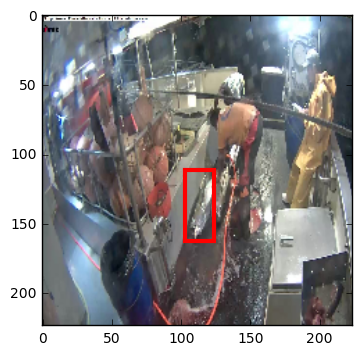

In [56]:
show_bb(0)

### Create & train model

Since we're not allowed (by the kaggle rules) to manually annotate the test set, we'll need to create a model that predicts the locations of the bounding box on each image. To do so, we create a model with multiple outputs: it will predict both the type of fish (the 'class'), and the 4 bounding box coordinates. We prefer this approach to only predicting the bounding box coordinates, since we hope that giving the model more context about what it's looking for will help it with both tasks.

In [5]:
p=0.6

In [6]:
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

NameError: name 'conv_layers' is not defined

Since we have multiple outputs, we need to provide them to the model constructor in an array, and we also need to say what loss function to use for each. We also weight the bounding box loss function down by 1000x since the scale of the cross-entropy loss and the MSE is very different.

In [86]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

In [87]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 1s - loss: 6.1534 - bb_loss: 5027.6558 - class_loss: 1.1258 - bb_acc: 0.3970 - class_acc: 0.6732 - val_loss: 5.0149 - val_bb_loss: 4098.7061 - val_class_loss: 0.9162 - val_bb_acc: 0.4540 - val_class_acc: 0.8400
Epoch 2/3
3277/3277 [==============================] - 1s - loss: 5.0483 - bb_loss: 4723.7241 - class_loss: 0.3245 - bb_acc: 0.4791 - class_acc: 0.8962 - val_loss: 4.1905 - val_bb_loss: 3876.8253 - val_class_loss: 0.3136 - val_bb_acc: 0.5340 - val_class_acc: 0.9380
Epoch 3/3
3277/3277 [==============================] - 1s - loss: 4.4175 - bb_loss: 4249.6727 - class_loss: 0.1678 - bb_acc: 0.5349 - class_acc: 0.9509 - val_loss: 3.6945 - val_bb_loss: 3406.7987 - val_class_loss: 0.2877 - val_bb_acc: 0.5720 - val_class_acc: 0.9460


In [88]:
model.optimizer.lr = 1e-5

In [89]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 1s - loss: 3.6777 - bb_loss: 3586.1524 - class_loss: 0.0915 - bb_acc: 0.5886 - class_acc: 0.9704 - val_loss: 3.2501 - val_bb_loss: 3014.3022 - val_class_loss: 0.2358 - val_bb_acc: 0.6260 - val_class_acc: 0.9600
Epoch 2/10
3277/3277 [==============================] - 1s - loss: 2.9034 - bb_loss: 2832.7123 - class_loss: 0.0707 - bb_acc: 0.6298 - class_acc: 0.9805 - val_loss: 2.6480 - val_bb_loss: 2405.0350 - val_class_loss: 0.2430 - val_bb_acc: 0.6600 - val_class_acc: 0.9600
Epoch 3/10
3277/3277 [==============================] - 1s - loss: 2.0618 - bb_loss: 2002.3679 - class_loss: 0.0594 - bb_acc: 0.6530 - class_acc: 0.9835 - val_loss: 1.9974 - val_bb_loss: 1741.0997 - val_class_loss: 0.2563 - val_bb_acc: 0.6880 - val_class_acc: 0.9560
Epoch 4/10
3277/3277 [==============================] - 1s - loss: 1.2993 - bb_loss: 1247.6213 - class_loss: 0.0517 - bb_acc: 0.7052 - class_acc: 0.9854

Excitingly, it turned out that the classification model is much improved by giving it this additional task. Let's see how well the bounding box model did by taking a look at its output.

In [90]:
pred = model.predict(conv_val_feat[0:10])

In [91]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

The image shows that it can find fish that are tricky for us to see!

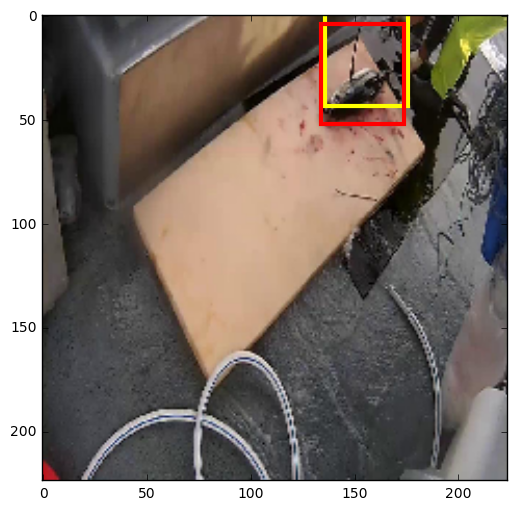

In [92]:
show_bb_pred(6)

In [93]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

500/500 [==============================] - 0s     


[0.63268272674083714,
 358.69855560302733,
 0.27398415758460759,
 0.81199999904632569,
 0.95999999999999996]

In [95]:
model.save_weights(path+'results/bn_anno.h5')

In [57]:
model.load_weights(path+'results/bn_anno.h5')

## Larger size

### Set up data

Let's see if we get better results if we use larger images. We'll use 640x360, since it's the same shape as the most common size we saw earlier (1280x720), without being too big.

In [105]:
trn = get_data(path+'train', (360,640))
val = get_data(path+'valid', (360,640))

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


The image shows that things are much clearer at this size.

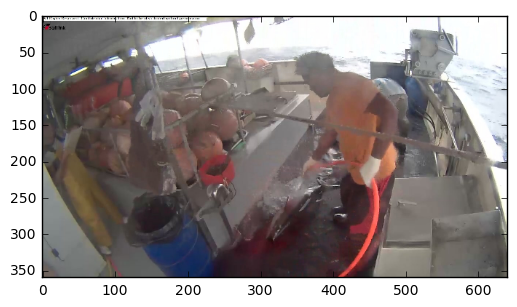

In [106]:
plot(trn[0])

In [107]:
test = get_data(path+'test', (360,640))

Found 1000 images belonging to 1 classes.


In [108]:
save_array(path+'results/trn_640.dat', trn)
save_array(path+'results/val_640.dat', val)

In [109]:
save_array(path+'results/test_640.dat', test)

In [110]:
trn = load_array(path+'results/trn_640.dat')
val = load_array(path+'results/val_640.dat')

We can now create our VGG model - we'll need to tell it we're not using the normal 224x224 images, which also means it won't include the fully connected layers (since they don't make sense for non-default sizes). We will also remove the last max pooling layer, since we don't want to throw away information yet.

In [131]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

We can now pre-compute the output of the convolutional part of VGG.

In [112]:
conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)

3277/3277 [==============================] - 427s   


In [113]:
save_array(path+'results/conv_val_640.dat', conv_val_feat)
save_array(path+'results/conv_trn_640.dat', conv_trn_feat)

In [114]:
conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

1000/1000 [==============================] - 130s   


In [115]:
save_array(path+'results/conv_test_640.dat', conv_test_feat)

In [132]:
conv_val_feat = load_array(path+'results/conv_val_640.dat')
conv_trn_feat = load_array(path+'results/conv_trn_640.dat')

In [133]:
conv_test_feat = load_array(path+'results/conv_test_640.dat')

### Fully convolutional net (FCN)

Since we're using a larger input, the output of the final convolutional layer is also larger. So we probably don't want to put a dense layer there - that would be a *lot* of parameters! Instead, let's use a fully convolutional net (FCN); this also has the benefit that they tend to generalize well, and also seems like a good fit for our problem (since the fish are a small part of the image).

In [134]:
conv_layers,_ = split_at(vgg640, Convolution2D)

I'm not using any dropout, since I found I got better results without it.

In [135]:
nf=128; p=0.

In [136]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Convolution2D(8,3,3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [137]:
lrg_model = Sequential(get_lrg_layers())

th


In [138]:
lrg_model.summary()

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.12-64/lock_dir/lock
Problem occurred during compilation with the command line below:
/usr/bin/g++ -shared -g -O3 -fno-math-errno -Wno-unused-label -Wno-unused-variable -Wno-write-strings -march=broadwell -mmmx -mno-3dnow -msse -msse2 -msse3 -mssse3 -mno-sse4a -mcx16 -msahf -mmovbe -maes -mno-sha -mpclmul -mpopcnt -mabm -mno-lwp -mfma -mno-fma4 -mno-xop -mbmi -mbmi2 -mno-tbm -mavx -mavx2 -msse4.2 -msse4.1 -mlzcnt -mrtm -mhle -mrdrnd -mf16c -mfsgsbase -mno-rdseed -mno-prfchw -mno-adx -mfxsr -mxsave -mxsaveopt -mno-avx512f -mno-avx512er -mno-avx512cd -mno-avx512pf -mno-prefetchwt1 -mno-clflushopt -mno-xsavec -mno-xsaves -mno-avx512dq -mno-avx512bw -mno-avx512vl -mno-avx512ifma -mno-avx512vbmi -mno-clwb -mno-pcommit -mno-mwaitx --param l1-cache-size=32 --param l1-cache-line-size=64 --param l2-cache-size=46080 -mtune=broadwell -DNPY_NO_DEPRECATED_API=NP

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_22 (BatchNorma(None, 512, 22, 40)   1024        batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________


OSError: [Errno 12] Cannot allocate memory

In [139]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [140]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Problem occurred during compilation with the command line below:
/usr/bin/g++ -shared -g -O3 -fno-math-errno -Wno-unused-label -Wno-unused-variable -Wno-write-strings -march=broadwell -mmmx -mno-3dnow -msse -msse2 -msse3 -mssse3 -mno-sse4a -mcx16 -msahf -mmovbe -maes -mno-sha -mpclmul -mpopcnt -mabm -mno-lwp -mfma -mno-fma4 -mno-xop -mbmi -mbmi2 -mno-tbm -mavx -mavx2 -msse4.2 -msse4.1 -mlzcnt -mrtm -mhle -mrdrnd -mf16c -mfsgsbase -mno-rdseed -mno-prfchw -mno-adx -mfxsr -mxsave -mxsaveopt -mno-avx512f -mno-avx512er -mno-avx512cd -mno-avx512pf -mno-prefetchwt1 -mno-clflushopt -mno-xsavec -mno-xsaves -mno-avx512dq -mno-avx512bw -mno-avx512vl -mno-avx512ifma -mno-avx512vbmi -mno-clwb -mno-pcommit -mno-mwaitx --param l1-cache-size=32 --param l1-cache-line-size=64 --param l2-cache-size=46080 -mtune=broadwell -DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -m64 -fPIC -I/home/ubuntu/anaconda2/lib/python2.7/site-packages/numpy/core/include -I/home/ubuntu/anaconda2/include/python2.7 -I/home/ubuntu/a

OSError: [Errno 12] Cannot allocate memory

In [ ]:
lrg_model.optimizer.lr=1e-5

In [ ]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

When I submitted the results of this model to Kaggle, I got the best single model results of any shown here (ranked 22nd on the leaderboard as at Dec-6-2016.)

In [ ]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

In [ ]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

In [ ]:
lrg_model.evaluate(conv_val_feat, val_labels)

Another benefit of this kind of model is that the last convolutional layer has to learn to classify each part of the image (since there's only an average pooling layer after). Let's create a function that grabs the output of this layer (which is the 4th-last layer of our model).

In [ ]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-4].output)

In [ ]:
def get_cm(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).

In [ ]:
inp = np.expand_dims(conv_val_feat[0], 0)
np.round(lrg_model.predict(inp)[0],2)

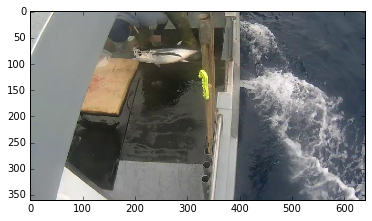

In [883]:
plt.imshow(to_plot(val[0]))

In [ ]:
cm = get_cm(inp, 0)

The heatmap shows that (at very low resolution) the model is finding the fish!

In [ ]:
plt.imshow(cm, cmap="cool")

### All convolutional net heatmap

To create a higher resolution heatmap, we'll remove all the max pooling layers, and repeat the previous steps.

In [ ]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(8,3,3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [ ]:
lrg_model = Sequential(get_lrg_layers())

In [18]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_2 (BatchNorma (None, 512, 22, 40)   1024        batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_2[0][0]       
____________________________________________________________________________________________________
batchnormalization_3 (BatchNorma (None, 128, 22, 40)   256         convolution2d_14[0][0]           
____________________________________________________________________________________________________
convolution2d_15 (Convolution2D) (None, 128, 22, 40)   147584      batchnormalization_3[0][0]       
___________________________________________________________________________________________

In [19]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [891]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 11s - loss: 0.9377 - acc: 0.7128 - val_loss: 2.7022 - val_acc: 0.6260
Epoch 2/2
3277/3277 [==============================] - 10s - loss: 0.2603 - acc: 0.9271 - val_loss: 0.4385 - val_acc: 0.9080


In [892]:
lrg_model.optimizer.lr=1e-5

In [893]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 11s - loss: 0.1027 - acc: 0.9747 - val_loss: 0.3641 - val_acc: 0.9060
Epoch 2/6
3277/3277 [==============================] - 10s - loss: 0.0498 - acc: 0.9844 - val_loss: 0.2743 - val_acc: 0.9200
Epoch 3/6
3277/3277 [==============================] - 10s - loss: 0.0359 - acc: 0.9918 - val_loss: 0.2262 - val_acc: 0.9520
Epoch 4/6
3277/3277 [==============================] - 11s - loss: 0.0339 - acc: 0.9912 - val_loss: 0.1877 - val_acc: 0.9540
Epoch 5/6
3277/3277 [==============================] - 10s - loss: 0.0242 - acc: 0.9945 - val_loss: 0.2320 - val_acc: 0.9460
Epoch 6/6
3277/3277 [==============================] - 10s - loss: 0.0211 - acc: 0.9930 - val_loss: 0.1813 - val_acc: 0.9520


In [894]:
lrg_model.save_weights(path+'models/lrg_0mp.h5')

In [20]:
lrg_model.load_weights(path+'models/lrg_0mp.h5')

#### Create heatmap

In [21]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)

In [22]:
def get_cm2(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

In [23]:
inp = np.expand_dims(conv_val_feat[0], 0)

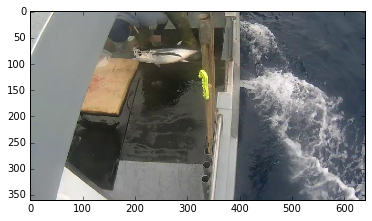

In [900]:
plt.imshow(to_plot(val[0]))

In [912]:
cm = get_cm2(inp, 0)

In [24]:
cm = get_cm2(inp, 4)

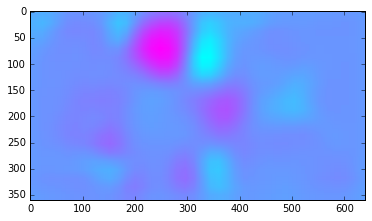

In [913]:
plt.imshow(cm, cmap="cool")

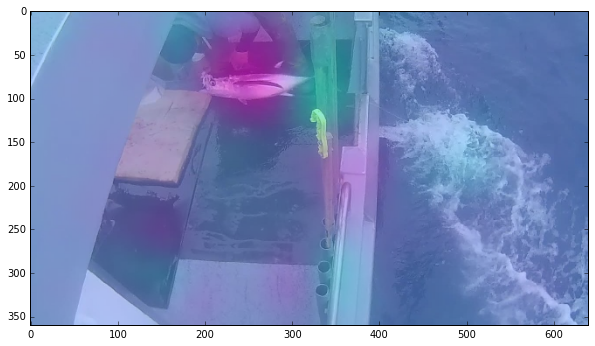

In [903]:
plt.figure(figsize=(10,10))
plot(val[0])
plt.imshow(cm, cmap="cool", alpha=0.5)

### Inception mini-net

Here's an example of how to create and use "inception blocks" - as you see, they use multiple different convolution filter sizes and concatenate the results together. We'll talk more about these next year.

In [198]:
def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample=(1, 1)):
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample, activation='relu', border_mode='same')(x)
    return BatchNormalization(axis=1)(x)

In [208]:
def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))

    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))

    branch_pool = AveragePooling2D(
        (3, 3), strides=(2, 2), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
              mode='concat', concat_axis=1)

In [271]:
inp = Input(vgg640.layers[-1].output_shape[1:]) 
x = BatchNormalization(axis=1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Convolution2D(8,3,3, border_mode='same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)

In [272]:
lrg_model = Model([inp], outp)

In [273]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [274]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 6s - loss: 1.3251 - acc: 0.5536 - val_loss: 1.4769 - val_acc: 0.5080
Epoch 2/2
3277/3277 [==============================] - 6s - loss: 0.4601 - acc: 0.8691 - val_loss: 0.9860 - val_acc: 0.7460


In [275]:
lrg_model.optimizer.lr=1e-5

In [277]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 6s - loss: 0.0260 - acc: 0.9945 - val_loss: 0.2117 - val_acc: 0.9480
Epoch 2/6
3277/3277 [==============================] - 6s - loss: 0.0240 - acc: 0.9957 - val_loss: 0.3007 - val_acc: 0.9280
Epoch 3/6
3277/3277 [==============================] - 6s - loss: 0.0120 - acc: 0.9976 - val_loss: 0.2506 - val_acc: 0.9500
Epoch 4/6
3277/3277 [==============================] - 6s - loss: 0.0060 - acc: 0.9991 - val_loss: 0.2389 - val_acc: 0.9480
Epoch 5/6
3277/3277 [==============================] - 6s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.2160 - val_acc: 0.9580
Epoch 6/6
3277/3277 [==============================] - 6s - loss: 0.0028 - acc: 0.9991 - val_loss: 0.2116 - val_acc: 0.9580


In [262]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 6s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.1610 - val_acc: 0.9540
Epoch 2/10
3277/3277 [==============================] - 6s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.1313 - val_acc: 0.9540
Epoch 3/10
3277/3277 [==============================] - 6s - loss: 0.0995 - acc: 0.9707 - val_loss: 0.4845 - val_acc: 0.8760
Epoch 4/10
3277/3277 [==============================] - 6s - loss: 0.1335 - acc: 0.9551 - val_loss: 0.3103 - val_acc: 0.9300
Epoch 5/10
3277/3277 [==============================] - 6s - loss: 0.0634 - acc: 0.9780 - val_loss: 0.2923 - val_acc: 0.9340
Epoch 6/10
3277/3277 [==============================] - 6s - loss: 0.0205 - acc: 0.9930 - val_loss: 0.2316 - val_acc: 0.9500
Epoch 7/10
3277/3277 [==============================] - 6s - loss: 0.0049 - acc: 0.9997 - val_loss: 0.2048 - val_acc: 0.9660
Epoch 8/10
3277/3277 [==============================] - 6s - loss: 0.0016 - ac

In [110]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

In [153]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

## Pseudo-labeling

In [14]:
preds = model.predict([conv_test_feat, test_sizes], batch_size=batch_size*2)

NameError: name 'test_sizes' is not defined

In [212]:
gen = image.ImageDataGenerator()

In [214]:
test_batches = gen.flow(conv_test_feat, preds, batch_size=16)

In [215]:
val_batches = gen.flow(conv_val_feat, val_labels, batch_size=4)

In [217]:
batches = gen.flow(conv_feat, trn_labels, batch_size=44)

In [292]:
mi = MixIterator([batches, test_batches, val_batches)

In [220]:
bn_model.fit_generator(mi, mi.N, nb_epoch=8, validation_data=(conv_val_feat, val_labels))

Epoch 1/8
4833/4777 [==============================] - 4s - loss: 0.2538 - acc: 0.9462 - val_loss: 0.1313 - val_acc: 0.9700
Epoch 2/8
 192/4777 [>.............................] - ETA: 2s - loss: 0.1972 - acc: 0.9635

/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:1494: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


4833/4777 [==============================] - 4s - loss: 0.2231 - acc: 0.9491 - val_loss: 0.0820 - val_acc: 0.9820
Epoch 3/8
4833/4777 [==============================] - 3s - loss: 0.1860 - acc: 0.9545 - val_loss: 0.0580 - val_acc: 0.9840
Epoch 4/8
4833/4777 [==============================] - 3s - loss: 0.1559 - acc: 0.9663 - val_loss: 0.0521 - val_acc: 0.9840
Epoch 5/8
4825/4777 [==============================] - 3s - loss: 0.1366 - acc: 0.9693 - val_loss: 0.0422 - val_acc: 0.9840
Epoch 6/8
4833/4777 [==============================] - 3s - loss: 0.1303 - acc: 0.9704 - val_loss: 0.0195 - val_acc: 0.9940
Epoch 7/8
4833/4777 [==============================] - 3s - loss: 0.1283 - acc: 0.9708 - val_loss: 0.0133 - val_acc: 0.9940
Epoch 8/8
4833/4777 [==============================] - 4s - loss: 0.1199 - acc: 0.9752 - val_loss: 0.0247 - val_acc: 0.9900


## Resnet

In [6]:
from resnet50 import Resnet50
rs_model = Resnet50(include_top=False)

In [7]:
trn_features = rs_model.model.predict_generator(batches, batches.nb_sample)

In [8]:
val_features = rs_model.model.predict_generator(val_batches, val_batches.nb_sample)

In [9]:
test_features = rs_model.model.predict_generator(test_batches, test_batches.nb_sample)

In [10]:
save_array(path+'results/trn_features.dat', trn_features)
save_array(path+'results/val_features.dat', val_features)

In [11]:
save_array(path+'results/test_features.dat', test_features)

In [26]:
def get_fc_layers(p):
    return [
        BatchNormalization(axis=1, input_shape=rs_model.model.output_shape[1:]),
        Flatten(),
        Dropout(p/2),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
        ]

In [27]:
fc_model = Sequential(get_fc_layers(0.7))

In [28]:
fc_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
fc_model.fit(trn_features, trn_labels, validation_data=(val_features, val_labels), nb_epoch=2, batch_size=batch_size)

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 6s - loss: 0.2379 - acc: 0.9326 - val_loss: 0.2685 - val_acc: 0.9400
Epoch 2/2
3277/3277 [==============================] - 6s - loss: 0.1313 - acc: 0.9582 - val_loss: 0.3035 - val_acc: 0.9420


In [32]:
fc_model.optimizer.lr = 0.000001

In [31]:
fc_model.save_weights(path+'results/resnet_0.3035_loss.h5')

In [35]:
fc_model.fit(trn_features, trn_labels, validation_data=(val_features, val_labels), nb_epoch=2, batch_size=batch_size)

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 6s - loss: 0.0581 - acc: 0.9826 - val_loss: 0.2624 - val_acc: 0.9580
Epoch 2/2
3277/3277 [==============================] - 6s - loss: 0.0432 - acc: 0.9863 - val_loss: 0.2513 - val_acc: 0.9580


In [36]:
fc_model.save_weights(path+'results/resnet_0.2513_loss.h5')

In [24]:
fc_model.fit(trn_features, trn_labels, validation_data=(val_features, val_labels), nb_epoch=2, batch_size=batch_size)

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 6s - loss: 0.0346 - acc: 0.9927 - val_loss: 0.2721 - val_acc: 0.9600
Epoch 2/2
3277/3277 [==============================] - 6s - loss: 0.0264 - acc: 0.9939 - val_loss: 0.2708 - val_acc: 0.9540


In [25]:
fc_model.save_weights(path+'results/resnet_0.2708_loss.h5')

In [27]:
fc_model.load_weights(path+'results/resnet_1_3860.h5')

In [28]:
fc_model.fit(trn_features, trn_labels, validation_data=(val_features, val_labels), nb_epoch=2, batch_size=batch_size)

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 6s - loss: 1.6383 - acc: 0.4764 - val_loss: 2.3331 - val_acc: 0.3520
Epoch 2/2
3277/3277 [==============================] - 6s - loss: 1.2720 - acc: 0.5810 - val_loss: 2.3038 - val_acc: 0.3860


In [12]:
def get_ap_layers(p):
    return [
        GlobalAveragePooling2D(input_shape=rs_model.model.output_shape[1:]),
        Dropout(p),
        Dense(8, activation='softmax')
    ]

In [13]:
ap_model = Sequential(get_ap_layers(0.15))
ap_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

th


In [16]:
ap_model.fit(trn_features, trn_labels, validation_data=(val_features, val_labels), nb_epoch=3, batch_size=batch_size)

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 0s - loss: 0.3814 - acc: 0.8847 - val_loss: 0.4077 - val_acc: 0.8700
Epoch 2/3
3277/3277 [==============================] - 0s - loss: 0.3608 - acc: 0.8859 - val_loss: 0.3980 - val_acc: 0.8740
Epoch 3/3
3277/3277 [==============================] - 0s - loss: 0.3327 - acc: 0.8972 - val_loss: 0.4330 - val_acc: 0.8240


In [15]:
ap_model.fit(trn_features, trn_labels, validation_data=(val_features, val_labels), nb_epoch=3, batch_size=batch_size)

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 0s - loss: 0.5772 - acc: 0.8004 - val_loss: 0.5256 - val_acc: 0.8240
Epoch 2/3
3277/3277 [==============================] - 0s - loss: 0.4865 - acc: 0.8367 - val_loss: 0.4806 - val_acc: 0.8320
Epoch 3/3
3277/3277 [==============================] - 0s - loss: 0.4406 - acc: 0.8575 - val_loss: 0.4222 - val_acc: 0.8760


In [41]:
ap_model.save_weights(path+'results/resnet_ap_1.7030.h5')

In [49]:
preds = fc_model.predict(test_features)

In [65]:
batches = get_batches(path+'train', batch_size=batch_size, target_size=(360,640))
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False, target_size=(360,640))
test_batches = get_batches(path+'test', batch_size=batch_size*2, shuffle=False, target_size=(360,640))



Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [66]:
trn_features = rs_model.model.predict_generator(batches, batches.nb_sample)
val_features = rs_model.model.predict_generator(val_batches, val_batches.nb_sample)
test_features = rs_model.model.predict_generator(test_batches, test_batches.nb_sample)

MemoryError: Error allocating 1854799872 bytes of device memory (out of memory).
Apply node that caused the error: GpuElemwise{Composite{((i0 - i1) * i2)},no_inplace}(GpuElemwise{add,no_inplace}.0, GpuReshape{4}.0, GpuElemwise{Composite{(i0 / sqrt(clip((i1 + i2), i3, i4)))},no_inplace}.0)
Toposort index: 1025
Inputs types: [CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, (True, False, True, True)), CudaNdarrayType(float32, (True, False, True, True))]
Inputs shapes: [(128, 256, 89, 159), (1, 256, 1, 1), (1, 256, 1, 1)]
Inputs strides: [(3622656, 14151, 159, 1), (0, 1, 0, 0), (0, 1, 0, 0)]
Inputs values: ['not shown', 'not shown', 'not shown']
Outputs clients: [[GpuElemwise{Composite{(Switch(i0, (i1 + i2), (i3 + i2)) + Switch(i0, (i4 + i5), (i6 + i5)))}}[(0, 3)](GpuFromHost.0, GpuElemwise{Composite{((i0 - i1) * i2)},no_inplace}.0, GpuReshape{4}.0, GpuElemwise{Composite{((i0 - i1) * i2)},no_inplace}.0, GpuElemwise{Composite{((i0 - i1) * i2)},no_inplace}.0, GpuReshape{4}.0, GpuElemwise{Composite{((i0 - i1) * i2)},no_inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## Submit

In [38]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)

In [829]:
lrg_model.evaluate(conv_val_feat, val_labels, batch_size*2)

500/500 [==============================] - 0s     


[0.11417267167568207, 0.97199999332427978]

In [53]:
preds = ap_model.predict(conv_test_feat, batch_size=batch_size)

Exception: Error when checking : expected globalaveragepooling2d_input_6 to have shape (None, 2048, 7, 7) but got array with shape (1000, 512, 14, 14)

In [48]:
preds = fc_model.predict(conv_test_feat, batch_size=batch_size)

500/500 [==============================] - 0s     


In [99]:
preds = preds[1]

In [25]:
test = load_array(path+'results/test_640.dat')

In [5]:
test = load_array(path+'results/test.dat')

In [26]:
preds = conv_model.predict(test, batch_size=32)

In [50]:
subm = do_clip(preds,0.80)

In [51]:
subm_name = path+'results/subm_rs_learning_rate_clip80.gz'

In [43]:
# classes = sorted(batches.class_indices, key=batches.class_indices.get)
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [52]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_06237.jpg,0.793981,0.203020,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571
1,img_06893.jpg,0.800000,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.140181
2,img_02082.jpg,0.800000,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571
3,img_06261.jpg,0.800000,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571
4,img_03628.jpg,0.800000,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571


In [53]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [54]:
FileLink(subm_name)

/home/ubuntu/data/fisheries/results/subm_rs_learning_rate_clip80.gz

## Full Resnet

In [55]:
from resnet50 import Resnet50
rs_model = Resnet50(include_top=True)

102309888/102853280 [============================>.] - ETA: 0s

In [56]:
model = rs_model.model

In [57]:
model.layers.pop()

In [58]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 3, 224, 224)   0           input_2[0][0]                    
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 3, 230, 230)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 64, 112, 112)  9472        zeropadding2d_2[0][0]            
___________________________________________________________________________________________

In [59]:
m = Dense(8, activation='softmax')(model.layers[-1].output)

In [60]:
model = Model(model.input, m)

In [61]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 3, 224, 224)   0           input_2[0][0]                    
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 3, 230, 230)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 64, 112, 112)  9472        zeropadding2d_2[0][0]            
___________________________________________________________________________________________

In [62]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [78]:
batch_size=8
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 327s - loss: nan - acc: 0.4525 - val_loss: nan - val_acc: 0.4720
Epoch 2/3
3277/3277 [==============================] - 327s - loss: nan - acc: 0.4525 - val_loss: nan - val_acc: 0.4720
Epoch 3/3
3277/3277 [==============================] - 327s - loss: nan - acc: 0.4525 - val_loss: nan - val_acc: 0.4720


In [82]:
model.optimizer.lr = 0.0000001
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 330s - loss: nan - acc: 0.4525 - val_loss: nan - val_acc: 0.4720
Epoch 2/3
3277/3277 [==============================] - 329s - loss: nan - acc: 0.4525 - val_loss: nan - val_acc: 0.4720
Epoch 3/3
3277/3277 [==============================] - 327s - loss: nan - acc: 0.4525 - val_loss: nan - val_acc: 0.4720


In [80]:
model.evaluate(val, val_labels, batch_size=16)

500/500 [==============================] - 9s     


[nan, 0.47199999999999998]

In [71]:
layers = model.layers
# Get the index of the first dense layer...
last_merge_idx = [index for index,layer in enumerate(layers) if type(layer) is BatchNormalization][-1]

In [72]:
last_merge_idx

172

In [73]:
for layer in layers[164:]: layer.trainable=True

In [74]:
for layer in layers[:163]: layer.trainable=False

In [75]:
layers[164]

In [76]:
layers[163]